<h3>Does precipitation level has anything to do with accident count?</h3>

`US_Accidents_Dec21_updated.csv` and `WeatherEvents_Jan2016-Dec2021.csv` are the main data.<br>
`US_Accidents_Dec21_updated.csv` - accident records for all the states.<br>
`WeatherEvents_Jan2016-Dec2021.csv` - weather events for all the states.<br><br>

Data of 5 cities from different states are extracted and combined.<br>
Producing 5 tables, `[City].csv`, which has **date** (2016-01-01 -> 2021-12-31) as row.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
names = ["Denver", "Miami", "Minneapolis", "New York", "Phoenix"]
category = ['W0000_0600','W0601_1200','W1201_1800','W1801_2359','WS1','WS2','WS3','WS4','AS0000_0600','AS0601_1200','AS1201_1800','AS1801_2359','Accident']
city_count = len(names)
cities = [ 
 pd.read_csv(names[0] + '.csv')
,pd.read_csv(names[1] + '.csv')
,pd.read_csv(names[2] + '.csv')
,pd.read_csv(names[3] + '.csv')
,pd.read_csv(names[4] + '.csv')
]
cities_cat = []

In [3]:
for i in range(city_count):
	cities_cat.append(cities[i][category].astype('category'))

In [4]:
cities_cat[0].describe()

,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,Accident
count,2192,2192,2192,2192,506,342,344,408,2192,2192,2192,2192,2192
unique,7,6,6,6,5,4,4,5,5,5,5,5,2
top,Clear,Clear,Clear,Clear,Light,Light,Light,Light,0,0,0,0,True
freq,1686,1850,1848,1784,394,236,156,304,1244,1165,1495,1929,1476


In [5]:
print("Weather type: ", cities_cat[0]['W0000_0600'].unique(), end ='\n\n')
print("Weather severity: ", cities_cat[0]['WS1'].unique(), end ='\n\n')
print("Accident severity: ", cities_cat[0]['AS0000_0600'].unique())

Weather type:  ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold']
Categories (7, object): ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold']

Weather severity:  [NaN, 'Light', 'Moderate', 'Severe', 'UNK', 'Heavy']
Categories (5, object): ['Light', 'Moderate', 'Severe', 'UNK', 'Heavy']

Accident severity:  [0, 2, 3, 4, 1]
Categories (5, int64): [0, 2, 3, 4, 1]


Types of analysis to do (Add if you think it is relevant):
   1. Correlation Matrix / Heatmap [ sb.heatmap(jointDF.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f") ]
   2. No. of Weathers that occur from 2016 to 2021
   3. Total no. of accidents that happened for each weathers 
      [ legnd_data = pkmndata[pkmndata["Legendary"] == True] , print("Number of Legendary Pokemons :", len(legnd_data)) ]
   4. Uni-Variate Linear Regression (Predictor = precipitation)
   5. Goodness of Fit of the Model
   6. Regression with random train-test split
   7. Simple Decision tree (Response = Accident[T/F], Predictor = precipitation) [done in 
   8. Classification tree with Random Train-Test Split [done] 
   9. Prediction of Accident [can be done after finalising the rest]

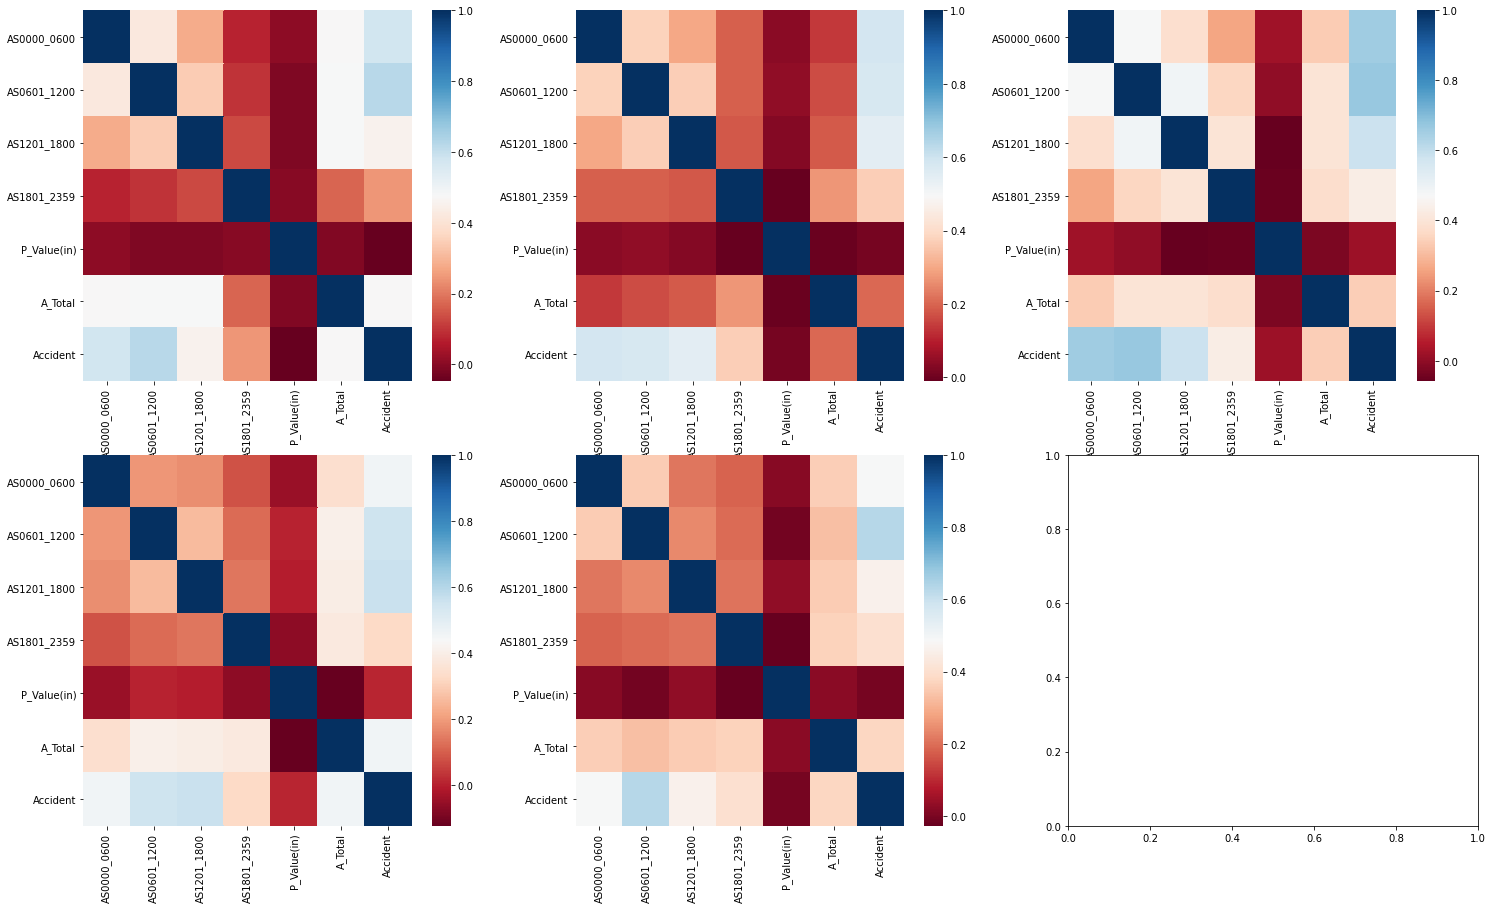

In [6]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))

for i in range(5):
	sb.heatmap(cities[i].corr(), ax = axes[int(i/3),i%3], cmap = "RdBu")

It seems to be have no relationship between preciptation level and accident count.

In [7]:
cities_cat[0].head()

,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,Accident
0,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
1,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
2,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
3,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False
4,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,False


<h3>Weather type vs Accident count</h3>

Row order:
1. Denver
2. Miami
3. Minneapolis
4. New York
5. Phoenix

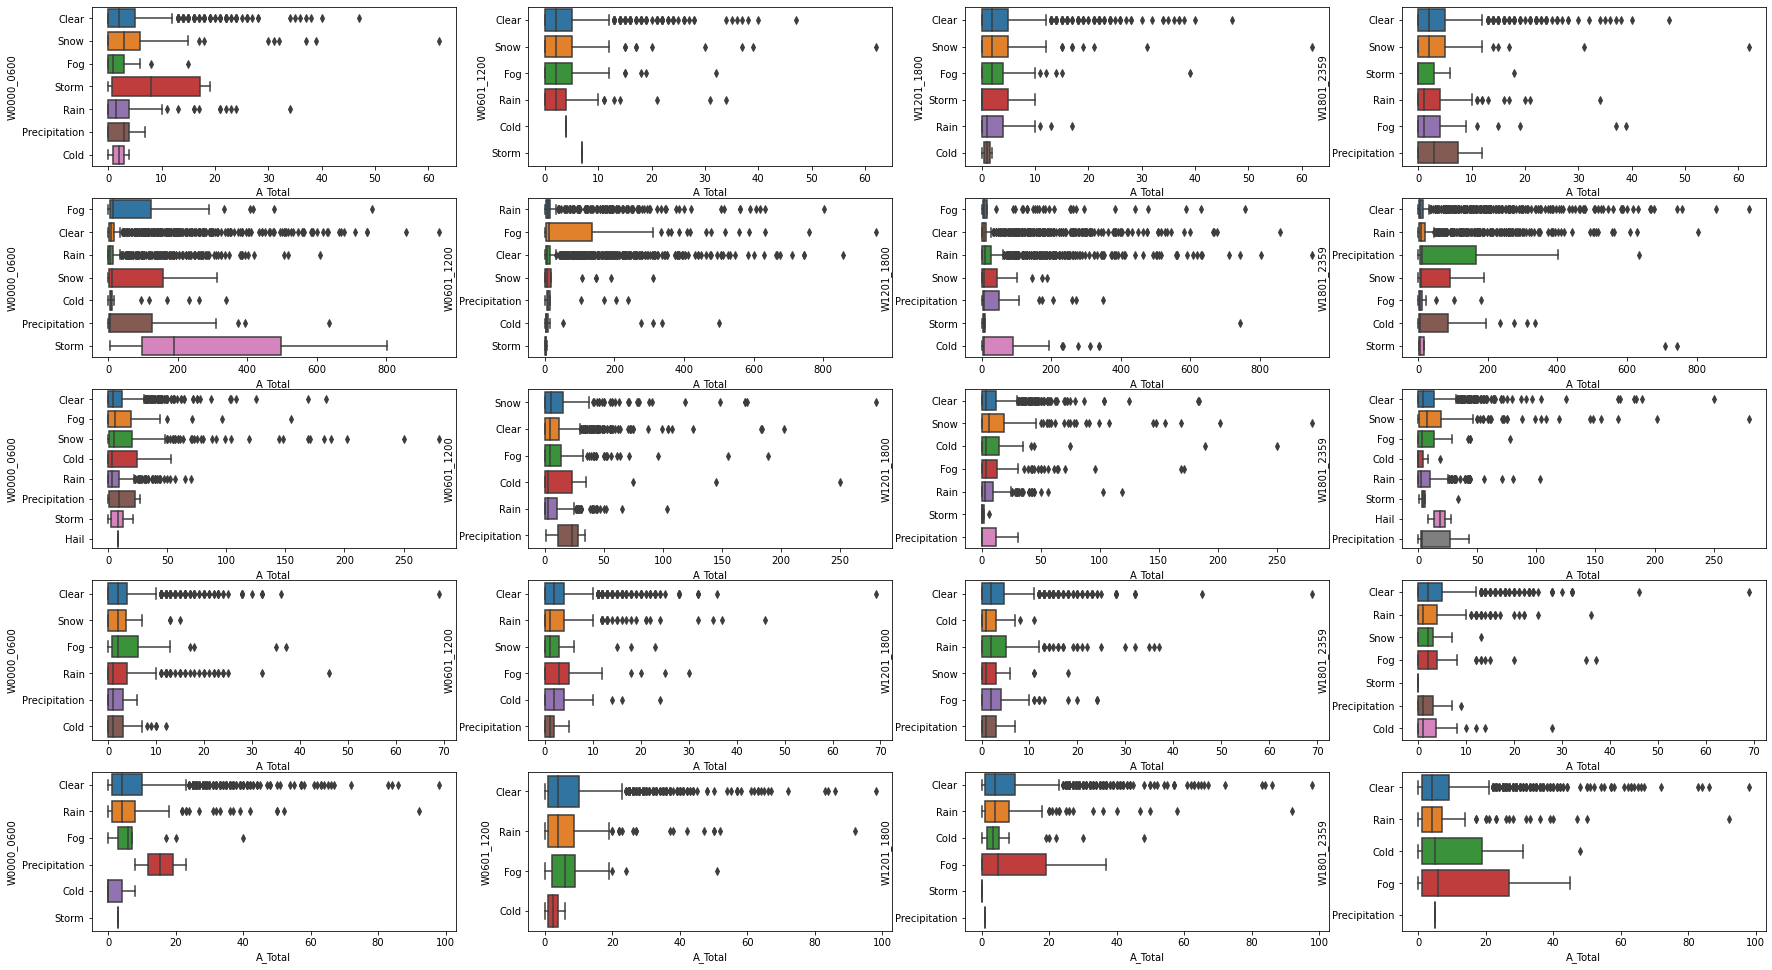

In [8]:
f, axes = plt.subplots(5, 4, figsize=(30, 17))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j] , data = cities[i], orient = 'h', ax = axes[i,j])

<h3>Weather serverity vs Accident count</h3>

Row order:
1. Denver
2. Miami
3. Minneapolis
4. New York
5. Phoenix

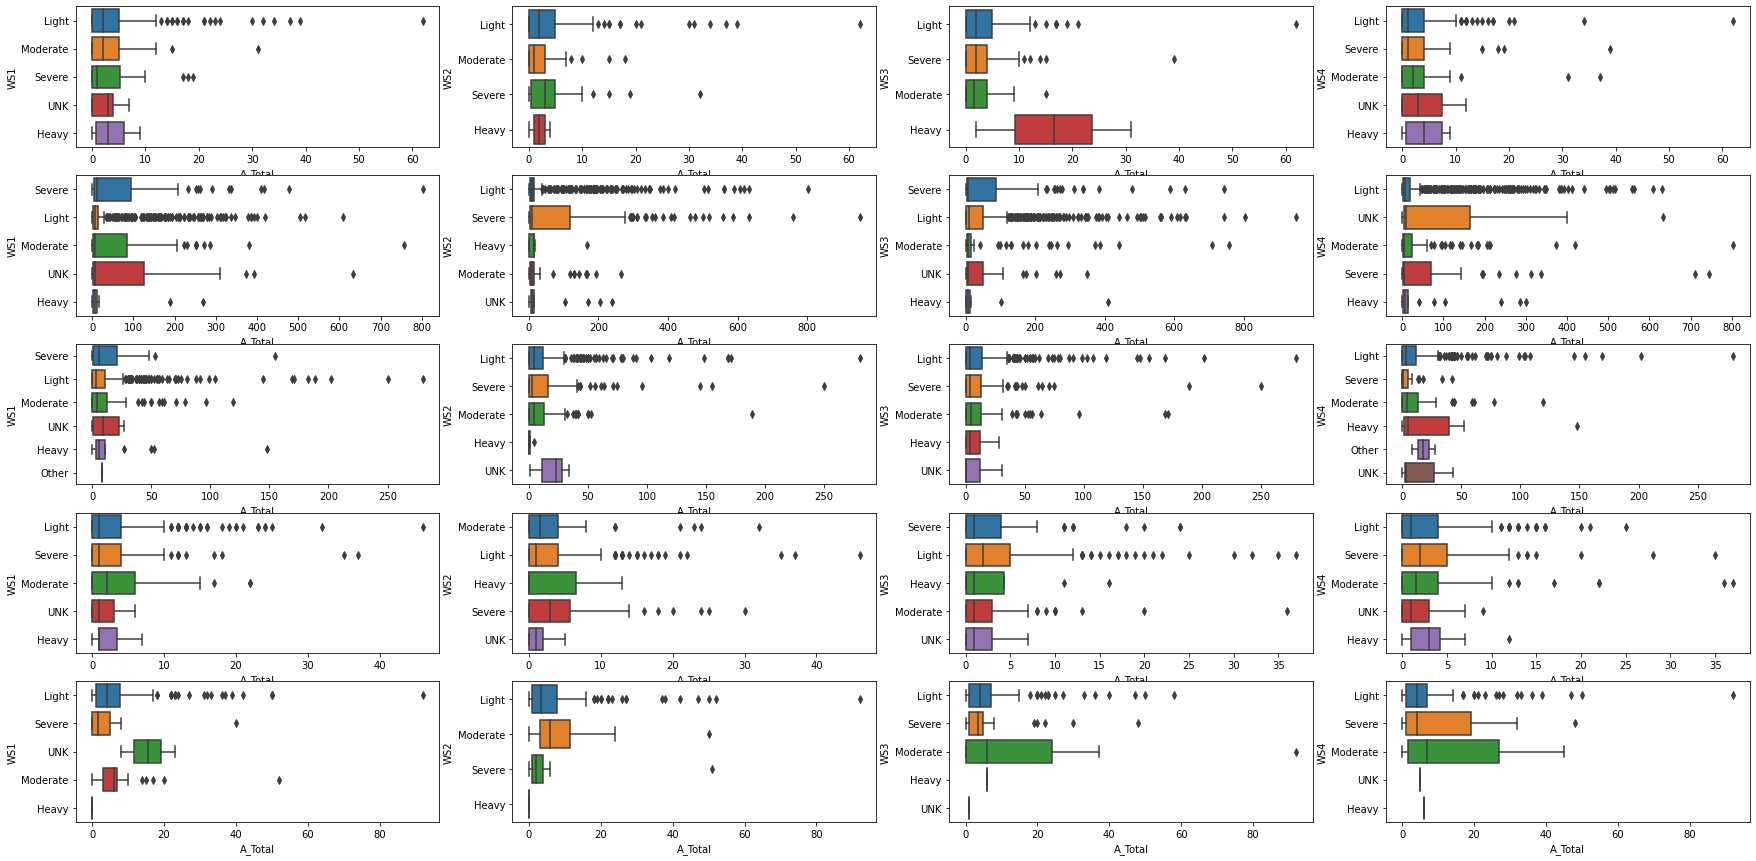

In [9]:
f, axes = plt.subplots(5, 4, figsize=(30, 15))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j + 4] , data = cities[i], orient = 'h', ax = axes[i,j])

<h3>Classifcation Tree to predict whether weather cause accident</h3>

Row order:
1. Denver
2. Miami
3. Minneapolis
4. New York
5. Phoenix

# CODE DUMP BELOW

In [35]:
wth = [[0]*4]*5
for i in range(city_count):
	for j in range(4):
		wth[i][j] = pd.DataFrame(cities[i][category[j]])


#  Changing the values of Accident Severity to True and false (0 = F, >0 = T)
accdnt = [[0]*4]*5
for i in range(city_count):
	for j in range(4):
		accdnt[i][j] = pd.DataFrame(cities[i][category[j+8]])
		accdnt[i][j] = accdnt[i][j].replace({0: False, 1: True, 2: True, 3: True, 4: True, 5: True})

feature_col = [['W0000_0600_Clear', 'W0000_0600_Cold', 'W0000_0600_Fog', 'W0000_0600_Rain', 'W0000_0600_Snow', 'W0000_0600_Storm'], ['W0601_1200_Clear', 'W0601_1200_Cold', 'W0601_1200_Fog', 'W0601_1200_Rain', 'W0601_1200_Snow', 'W0601_1200_Storm'], ['W1201_1800_Clear', 'W01201_1800_Cold', 'W1201_1800_Fog', 'W1201_1800_Rain', 'W1201_1800_Snow', 'W1201_1800_Storm'], ['W1801_2359_Clear', 'W01801_2359_Cold', 'W1801_2359_Fog', 'W1801_2359_Rain', 'W1801_2359_Snow', 'W1801_2359_Storm']]


odata = [[0]*4]*5
for i in range(city_count):
	for j in range(4):
		odata[i][j] = pd.get_dummies(wth[i][j])

#print(odata)   [dont have snow data why?]

dict = {'W0000_0600_Clear': 'Clear', 'W0601_1200_Clear':'Clear', 'W1201_1800_Clear':'Clear', 'W1801_2359_Clear':'Clear',
        'W0000_0600_Rain': 'Rain', 'W0601_1200_Rain':'Rain', 'W1201_1800_Rain':'Rain', 'W1801_2359_Rain':'Rain',
        'W0000_0600_Fog': 'Fog', 'W0601_1200_Fog':'Fog', 'W1201_1800_Fog':'Fog', 'W1801_2359_Fog':'Fog',
        'W0000_0600_Snow': 'Snow', 'W0601_1200_Snow':'Snow', 'W1201_1800_Snow':'Snow', 'W1801_2359_Snow':'Snow',
        'W0000_0600_Storm': 'Storm', 'W0601_1200_Storm':'Storm', 'W1201_1800_Storm':'Storm', 'W1801_2359_Storm':'Storm',
        'W0000_0600_Cold': 'Cold', 'W0601_1200_Cold':'Cold', 'W1201_1800_Cold':'Cold', 'W1801_2359_Cold':'Cold',}
 
# call rename () method
for i in range(city_count):
	for j in range(4):
		odata[i][j].rename(columns=dict,inplace=True)

# Isolating each cities' weather into a dataset (do we want to remove Cold weather? what is it anyway? ><)
#weather_cat = ['Clear', 'Rain', 'Fog', 'Snow', 'Storm', 'Cold']

weather_D = odata[0][0].append(odata[0][1], ignore_index = True)
for j in range(2):
	weather_D = weather_D.append(odata[0][j+2], ignore_index = True)
	weather_MM = odata[1][0].append(odata[1][j], ignore_index = True)
	weather_MP = odata[2][0].append(odata[2][j], ignore_index = True)
	weather_NY = odata[3][0].append(odata[3][j], ignore_index = True)
	weather_P = odata[4][0].append(odata[4][j], ignore_index = True)



#for i in range(4):
#	




Things to do: 
1. append the P_value for each of the cities, along with the AS timings(T/F)
2. Implement the classification tree onto it 
3. 

In [ ]:

cities[0]['P_Value(in)']